In [1]:
# Import Modules
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import numpy as np
from PIL import Image
# import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import ogr  # vector managment
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_mutual_info_score

# Import raster modules and other geo modules
import os
from osgeo import gdal, gdal_array
from osgeo import osr

# Set your own PATH!!! 
PATH = 'YOUR_PATH'

In [2]:
F1_score = []
OA = []
OE = []
CE = []

In [15]:
image = os.path.join(PATH, 'YOUR_EXPORTED_IMAGE.tif')

The image size is (836, 2014, 6)
Reshaped from (836, 2014, 6) to (1683704, 1)


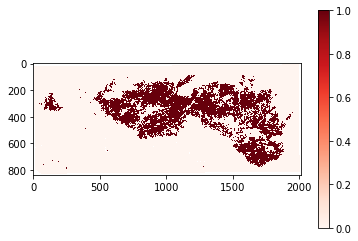

In [17]:

loaded_image = gdal.Open(image)

# if validation is None: 
#     print('Could not open {}'.format(fn)) 
#     sys.exit(1)

# empty array for full image 
img_validation = np.zeros((loaded_image.RasterYSize, loaded_image.RasterXSize, loaded_image.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(loaded_image.GetRasterBand(loaded_image.RasterCount).DataType))
# reading
for b in range(img_validation.shape[2]):
    img_validation[:, :, b] = loaded_image.GetRasterBand(b + 1).ReadAsArray()

print('The image size is {}'.format(img_validation.shape))

# take our full image, and reshape into long 2d array (nrow * ncol, nband) for e.g. classification
new_shape = (img_validation.shape[0] * img_validation.shape[1], 1)

# check the dimensionality 
validation_as_array = img_validation[:, :, loaded_image.RasterCount-1].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img_validation.shape,
                                        n=validation_as_array.shape))

cols_data = loaded_image.RasterXSize
rows_data = loaded_image.RasterYSize
bands_data = loaded_image.RasterCount

# Reshape the image back
valid_backshape = validation_as_array.reshape(rows_data,cols_data,1)


plt.imshow(img_validation[:,:,loaded_image.RasterCount-1], cmap='Reds', interpolation='none',vmin=0,
    vmax=1)
plt.colorbar()
# img = Image.fromarray(valid_backshape)
# img.save('proba_validation.tif')

In [18]:
# Check if I have NaN values in validation data
np.any(np.isnan(validation_as_array))

True

In [19]:
# Check if my data contains infinity values in data
np.all(np.isinf(validation_as_array))

False

In [20]:
# Change 0 to 99 and 1 to 100
validation_df = pd.DataFrame(validation_as_array)

In [21]:
# empty array for full image 
img_ = np.zeros((loaded_image.RasterYSize, loaded_image.RasterXSize, loaded_image.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(loaded_image.GetRasterBand(2).DataType))
# reading
# for b in range(img_.shape[2]):
#     img_[:, :, b] = image.GetRasterBand(b + 1).ReadAsArray()

images = range(1,loaded_image.RasterCount)
# print(images)
for i in images:
    
    # athens = 6, evia = 5, olympia = 5
    img_ = loaded_image.GetRasterBand(i).ReadAsArray()

#     print('The image size is {}'.format(img_.shape))

    # take our full image, and reshape into long 2d array (nrow * ncol, nband) for e.g. classification
    new_shape = (img_.shape[0] * img_.shape[1],1)

    # check the dimensionality 
    img_as_array = img_[:, :].reshape(new_shape)
#     print('Reshaped from {o} to {n}'.format(o=img_.shape,
#                                             n=img_as_array.shape))
    
    # clean memory 
    # validation = None

    # Check if I have NaN values in validation data
    np.any(np.isnan(img_as_array))

    # Check if my data contains infinity values in data
    np.all(np.isinf(validation_as_array))

    img_df = pd.DataFrame(img_as_array)
    # img_df

    # Change NaN values to 999
    cleared_data = np.nan_to_num(img_df, nan=999)
    img_df = pd.DataFrame(cleared_data)
    img_df
    # Create a dataset without rows containing 999 values (values representing NaN values)
    # These rows can strongly incluence various models for predicting the number of clusters, epsilon value, etc.

    NaN_data = img_df.loc[img_df[0] == 999]
    NaN_data
    # Select only data not containing NaN values
    prepared_data = img_df[img_df[0] != 999]
    prepared_data

    # Save their indexes for reshaping the results
    prepared_data_index = prepared_data.index
    NaN_data_index = NaN_data.index

    validation_df = pd.DataFrame(validation_as_array)
    # validation_df

    # Select only data not containing NaN values
    prepared_validation = validation_df.iloc[prepared_data_index]
    # prepared_validation

    accuracy_K = accuracy_score(prepared_validation, prepared_data)*100
    cm = confusion_matrix(prepared_validation, prepared_data)
    # omission_e = cm[1,0]/(cm[1,0]+cm[1,1])*100
    # commission_e = cm[0,1]/(cm[1,1]+cm[0,1])*100
    f1Score = f1_score(prepared_validation, prepared_data, pos_label=1, average='binary')*100
    commission = (1-(precision_score(prepared_validation, prepared_data,pos_label=1)))*100
    omission = (1-(recall_score(prepared_validation, prepared_data,pos_label=1)))*100
    
    F1_score.append(f1Score)
    OA.append(accuracy_K)
    OE.append(omission)
    CE.append(commission)
    
    # print('accuracy: ',round(accuracy_K,2),'\nomission_e:',round(omission_e,2),'\ncommission_e:',round(commission_e,2),'\nf1Score:',round(f1Score,2))
    # print('f1Score / OA:\n',round(f1Score,2),'/',round(accuracy_K,2),'\nomission_e / commission_e:\n', round(omission_e,2),'/',round(commission_e,2))
    print(i)
    print('f1Score / OA:\n',round(f1Score,2),'/',round(accuracy_K,2),'\nomission_e / commission_e:\n', round(omission,2),'/',round(commission,2))

    # print(precision,recall)

1
f1Score / OA:
 68.66 / 84.73 
omission_e / commission_e:
 25.64 / 36.23
2
f1Score / OA:
 72.56 / 88.01 
omission_e / commission_e:
 29.54 / 25.22
3
f1Score / OA:
 73.83 / 89.05 
omission_e / commission_e:
 31.3 / 20.2
4
f1Score / OA:
 74.5 / 89.48 
omission_e / commission_e:
 31.68 / 18.08
5
f1Score / OA:
 75.06 / 89.8 
omission_e / commission_e:
 31.74 / 16.65


In [22]:
print(F1_score)
print(OA)

print(OE)
print(CE)

[28.737124980600687, 68.65877360755131, 72.5561621084052, 73.83259276617606, 74.50083828684652, 75.05551602626656]
[67.96448045629518, 84.73466221707895, 88.01370831733045, 89.0500666620989, 89.4836688858032, 89.79689589083634]
[77.0923675951609, 25.64445165005339, 29.540232455429273, 31.30489229788733, 31.68337311947583, 31.739837761987555]
[61.45367692172846, 36.227200368246415, 25.218869503045337, 20.19937654240811, 18.0838869262688, 16.646584768933014]


In [23]:
# create labels for the table
labelsForTable = []
maxRange = 71

for i in range(3,maxRange+2,2):
    labelsForTable.append(str(i)+'x'+str(i))

# labelsForTable

In [26]:
# create the final table and export
table = pd.DataFrame(list(zip(labelsForTable, F1_score, OA, OE, CE)),
               columns =['speckle kernel window size','F1', 'OA','OE','CE'])

In [27]:
table

,speckle kernel window size,F1,OA,OE,CE
0,3x3,28.737125,67.964480,77.092368,61.453677
1,5x5,68.658774,84.734662,25.644452,36.227200
2,7x7,72.556162,88.013708,29.540232,25.218870
3,9x9,73.832593,89.050067,31.304892,20.199377
4,11x11,74.500838,89.483669,31.683373,18.083887
5,13x13,75.055516,89.796896,31.739838,16.646585


In [14]:
table.to_csv('Speckle_tuning_results.csv')